In [1]:
from nuisancelib import *
%matplotlib inline

# Merge dataframes containing real MRI data and segmentation statistics

In [2]:
real_files = pd.read_csv('../output/real_output.csv')
real_df = pd.DataFrame(real_files,columns=['Date', 'sid', 'ses', 'snr_total', 'TxRefAmp', 'AcquisitionTime', 'SAR',
                                'RepetitionTime', 'Shim1', 'Shim2', 'Shim3', 'Shim4',
                                'Shim5', 'Shim6', 'Shim7', 'Shim8', 'IOPD1', 'IOPD2',
                                'IOPD3', 'IOPD4', 'IOPD5', 'IOPD6'])

segstats = pd.read_csv('../output/segstats-volume.csv')
seg_df = pd.DataFrame(segstats,columns=['Date', 'sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"])
merged_df = pd.merge(real_df, seg_df, on=['sid', 'ses'], how='outer')
merged_df['Date_x'] = pd.to_datetime(merged_df['Date_x'], format="%Y%m%d")
merged_df.set_index('Date_x',inplace=True)
# merged_df

# Interpolate time and merge with earlier dataframe

In [3]:
df3 = pd.read_csv('../data/extractions/anat.csv', parse_dates=['Date'])
df3.set_index('Date', inplace=True)
df_reindexed = df3.reindex(pd.date_range(start=df3.index.min(), end=df3.index.max(), freq='1D'))  
df_reindexed.index.names = ['Date_x']
interpolated_df = df_reindexed.interpolate(method='time')
# interpolated_df

In [4]:
super_df = pd.merge(merged_df, interpolated_df, left_index=True, right_index=True, suffixes = ("_real", "_qa"))
# super_df

# get additional patient data i.e. subject id, session id, switch sex to binary, merge

In [5]:
demographic_df = pd.read_csv('../data/dbic/bids/participants.tsv', sep='\t')
demographic_df = demographic_df.rename(index=str, columns={"participant_id": "sid"})
final_df = super_df.join(demographic_df.set_index('sid'), on='sid', how='left')
# final_df

In [6]:
# disable chained assignments
pd.options.mode.chained_assignment = None 

expanded_df = pd.DataFrame(final_df,columns=['sid', 'ses', 'Background', "Left-Accumbens-area", 
                                        "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white", 'age', 
                                             'sex', 'snr_total_qa', 'IOPD1_real', 'IOPD2_real', 'IOPD3_real', 
                                             'IOPD4_real', 'IOPD5_real', 'IOPD6_real'])
expanded_df = expanded_df.reset_index()
expanded_df = expanded_df.rename(columns={'Date_x': 'Date'})
expanded_df['sex_male'] = [0 for item in range(len(expanded_df))]
expanded_df.sex_male[expanded_df.sex == 'M'] = int(1)
# expanded_df

In [7]:
dicom_data = pd.read_csv('../output/dicom_data.csv')
dicom_data = pd.DataFrame(dicom_data,columns=['sid', 'ses', 'PatientWeight'])
July17_df = pd.merge(expanded_df, dicom_data, on=['sid', 'ses'], how='left')
# July17_df

In [8]:
Oct14_df = pd.DataFrame(July17_df, columns=['Date', 'gray', 'age', 'snr_total_qa', 'IOPD1_real', 'IOPD2_real', 'IOPD3_real', 
                                              'IOPD4_real', 'IOPD5_real', 'IOPD6_real', 'sex_male', 'PatientWeight', 
                                              'Seasonal (sin)', 'Seasonal (cos)'])

# regress with both snr_total_qa and seasonal data

Statistically significant variables: ['const', 'age', 'sex_male', 'PatientWeight', 'Seasonal (sin)', 'snr_total_qa', 'IOPD2_real']
FDR-corrected p-values:
            age | Original  p-value: 0.000777 | FDR-corrected p-value:  0.00233**
       sex_male | Original  p-value:  0.00354 | FDR-corrected p-value:  0.00532**
  PatientWeight | Original  p-value: 1.47e-07 | FDR-corrected p-value: 8.82e-07**
   snr_total_qa | Original  p-value:  0.00157 | FDR-corrected p-value:  0.00315**
           IOPD | Original  p-value:   0.0565 | FDR-corrected p-value:   0.0565
       Seasonal | Original  p-value:   0.0293 | FDR-corrected p-value:   0.0352**


                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.206
Method:                 Least Squares   F-statistic:                     6.615
Date:                Tue, 16 Jun 2020

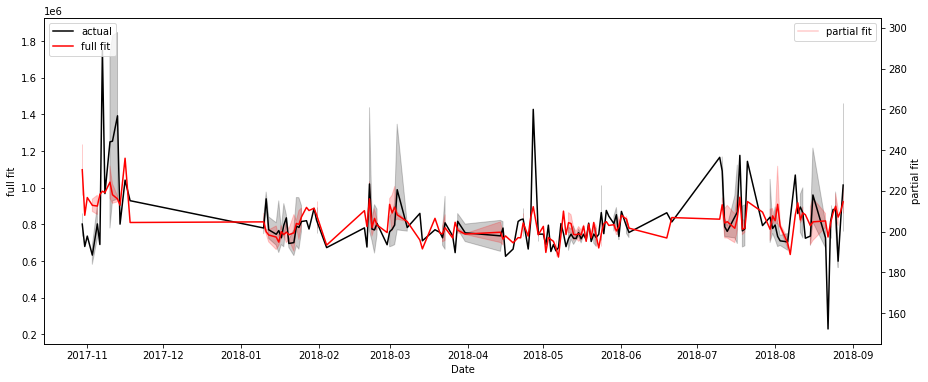

In [9]:
regress('gray', Oct14_df, real_data=True);

# regress with only snr_total_qa

In [10]:
regress('gray', Oct14_df, add_qa=True, add_seasonal=False, real_data=True, plot=False)

Statistically significant variables: ['const', 'age', 'sex_male', 'PatientWeight', 'snr_total_qa']
FDR-corrected p-values:
            age | Original  p-value: 0.000969 | FDR-corrected p-value:  0.00242**
       sex_male | Original  p-value:  0.00421 | FDR-corrected p-value:  0.00701**
  PatientWeight | Original  p-value: 2.42e-07 | FDR-corrected p-value: 1.21e-06**
   snr_total_qa | Original  p-value:   0.0135 | FDR-corrected p-value:   0.0169**
           IOPD | Original  p-value:   0.0851 | FDR-corrected p-value:   0.0851


                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     6.514
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           6.12e-09
Time:                        19:13:56   Log-Likelihood:                -

# regress with only seasonal data

In [11]:
regress('gray', Oct14_df, add_qa=False, real_data=True, plot=False)

Statistically significant variables: ['const', 'age', 'sex_male', 'PatientWeight', 'Seasonal (sin)', 'IOPD2_real']
FDR-corrected p-values:
            age | Original  p-value: 0.000982 | FDR-corrected p-value:  0.00246**
       sex_male | Original  p-value:  0.00425 | FDR-corrected p-value:  0.00708**
  PatientWeight | Original  p-value:  2.5e-07 | FDR-corrected p-value: 1.25e-06**
           IOPD | Original  p-value:   0.0933 | FDR-corrected p-value:   0.0933
       Seasonal | Original  p-value:   0.0336 | FDR-corrected p-value:    0.042**


                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     5.951
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           1.34e-08
Time:                        19:13:56   Log-Likelihood: 

# regress with neither snr_total_qa and seasonal data

In [12]:
regress('gray', Oct14_df, add_qa=False, add_seasonal=False, real_data=True, plot=False)

Statistically significant variables: ['const', 'age', 'sex_male', 'PatientWeight', 'IOPD2_real']
FDR-corrected p-values:
            age | Original  p-value:   0.0011 | FDR-corrected p-value:  0.00221**
       sex_male | Original  p-value:  0.00465 | FDR-corrected p-value:   0.0062**
  PatientWeight | Original  p-value: 3.26e-07 | FDR-corrected p-value:  1.3e-06**
           IOPD | Original  p-value:    0.115 | FDR-corrected p-value:    0.115


                            OLS Regression Results                            
Dep. Variable:                   gray   R-squared:                       0.185
Model:                            OLS   Adj. R-squared:                  0.156
Method:                 Least Squares   F-statistic:                     6.331
Date:                Sat, 13 Jun 2020   Prob (F-statistic):           4.43e-08
Time:                        19:13:56   Log-Likelihood:                -3518.8
No. Observations:                 261   AIC:                             7058

# get significance of snr_total_qa for all segmentation statistics

In [13]:
targets = ['Background', "Left-Accumbens-area", "Left-Amygdala", "Left-Caudate", "Left-Hippocampus", "Left-Pallidum",
                                        "Left-Putamen", "Left-Thalamus-Proper", "Right-Accumbens-area", 
                                        "Right-Amygdala", "Right-Caudate", "Right-Hippocampus", "Right-Pallidum",
                                        "Right-Putamen", "Right-Thalamus-Proper", "csf", "gray", "white"]
scrape_var_significance(targets, 'snr_total_qa', July17_df)

FDR-corrected p-values:
            age | Original  p-value:    0.114 | FDR-corrected p-value:    0.228
       sex_male | Original  p-value: 1.11e-32 | FDR-corrected p-value: 6.63e-32**
  PatientWeight | Original  p-value: 0.000339 | FDR-corrected p-value:  0.00102**
   snr_total_qa | Original  p-value:    0.269 | FDR-corrected p-value:    0.323
           IOPD | Original  p-value:    0.543 | FDR-corrected p-value:    0.543
       Seasonal | Original  p-value:    0.182 | FDR-corrected p-value:    0.273


FDR-corrected p-values:
            age | Original  p-value:    0.508 | FDR-corrected p-value:    0.762
       sex_male | Original  p-value:    0.014 | FDR-corrected p-value:   0.0419**
  PatientWeight | Original  p-value:    0.318 | FDR-corrected p-value:    0.636
   snr_total_qa | Original  p-value:    0.981 | FDR-corrected p-value:    0.981
           IOPD | Original  p-value:  0.00248 | FDR-corrected p-value:   0.0149**
       Seasonal | Original  p-value:    0.879 | FDR-corrected 

FDR-corrected p-values:
            age | Original  p-value:    0.074 | FDR-corrected p-value:   0.0888
       sex_male | Original  p-value:  5.7e-13 | FDR-corrected p-value: 3.42e-12**
  PatientWeight | Original  p-value:  0.00827 | FDR-corrected p-value:   0.0165**
   snr_total_qa | Original  p-value:    0.862 | FDR-corrected p-value:    0.862
           IOPD | Original  p-value:   0.0237 | FDR-corrected p-value:   0.0356**
       Seasonal | Original  p-value:  0.00374 | FDR-corrected p-value:   0.0112**




,Variable,snr_total_qa p value,R2 value,FDR-corrected
0,Background,0.268868,0.466775,0.722752
1,Left-Accumbens-area,0.980640,0.103959,0.980640
2,Left-Amygdala,0.462431,0.328001,0.722752
3,Left-Caudate,0.088055,0.215853,0.396249
4,Left-Hippocampus,0.464155,0.217866,0.722752
5,Left-Pallidum,0.563611,0.519885,0.722752
6,Left-Putamen,0.464372,0.261736,0.722752
7,Left-Thalamus-Proper,0.300834,0.428157,0.722752
8,Right-Accumbens-area,0.569273,0.146147,0.722752
9,Right-Amygdala,0.748272,0.333926,0.841806


# get significance of seasonal for all segmentation statistics

In [14]:
scrape_var_significance(targets, 'Seasonal', July17_df)

FDR-corrected p-values:
            age | Original  p-value:    0.114 | FDR-corrected p-value:    0.228
       sex_male | Original  p-value: 1.11e-32 | FDR-corrected p-value: 6.63e-32**
  PatientWeight | Original  p-value: 0.000339 | FDR-corrected p-value:  0.00102**
   snr_total_qa | Original  p-value:    0.269 | FDR-corrected p-value:    0.323
           IOPD | Original  p-value:    0.543 | FDR-corrected p-value:    0.543
       Seasonal | Original  p-value:    0.182 | FDR-corrected p-value:    0.273


FDR-corrected p-values:
            age | Original  p-value:    0.508 | FDR-corrected p-value:    0.762
       sex_male | Original  p-value:    0.014 | FDR-corrected p-value:   0.0419**
  PatientWeight | Original  p-value:    0.318 | FDR-corrected p-value:    0.636
   snr_total_qa | Original  p-value:    0.981 | FDR-corrected p-value:    0.981
           IOPD | Original  p-value:  0.00248 | FDR-corrected p-value:   0.0149**
       Seasonal | Original  p-value:    0.879 | FDR-corrected 

FDR-corrected p-values:
            age | Original  p-value:    0.074 | FDR-corrected p-value:   0.0888
       sex_male | Original  p-value:  5.7e-13 | FDR-corrected p-value: 3.42e-12**
  PatientWeight | Original  p-value:  0.00827 | FDR-corrected p-value:   0.0165**
   snr_total_qa | Original  p-value:    0.862 | FDR-corrected p-value:    0.862
           IOPD | Original  p-value:   0.0237 | FDR-corrected p-value:   0.0356**
       Seasonal | Original  p-value:  0.00374 | FDR-corrected p-value:   0.0112**




,Variable,Seasonal p value,R2 value,FDR-corrected
0,Background,0.18204024682794348,0.466775,0.327672
1,Left-Accumbens-area,0.8785403210072759,0.103959,0.972959
2,Left-Amygdala,0.6380391076601631,0.328001,0.820336
3,Left-Caudate,0.9551548726187958,0.215853,0.972959
4,Left-Hippocampus,0.1684526092230895,0.217866,0.327672
5,Left-Pallidum,0.1598866201208293,0.519885,0.327672
6,Left-Putamen,0.08740580229326499,0.261736,0.224758
7,Left-Thalamus-Proper,0.21422013426755016,0.428157,0.350542
8,Right-Accumbens-area,0.04439641850610068,0.146147,0.210907
9,Right-Amygdala,0.9729593078533307,0.333926,0.972959


# versions used for this code

In [15]:
import pandas as pd, statsmodels as sm
pd.show_versions();
print("Statsmodels:  ", sm.__version__)


INSTALLED VERSIONS
------------------
commit           : None
python           : 3.6.4.final.0
python-bits      : 64
OS               : Darwin
OS-release       : 18.6.0
machine          : x86_64
processor        : i386
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.0.4
numpy            : 1.18.4
pytz             : 2017.3
dateutil         : 2.6.1
pip              : 20.1.1
setuptools       : 38.4.0
Cython           : 0.27.3
pytest           : 3.3.2
hypothesis       : None
sphinx           : 1.6.6
blosc            : None
feather          : None
xlsxwriter       : 1.0.2
lxml.etree       : 4.1.1
html5lib         : 1.0.1
pymysql          : None
psycopg2         : None
jinja2           : 2.10
IPython          : 6.2.1
pandas_datareader: None
bs4              : 4.5.3
bottleneck       : 1.2.1
fastparquet      : None
gcsfs            : None
lxml.etree       : 4.1.1
matplotlib       : 3.2.1
numexpr          : 2.